In [2]:
import keras
import tensorflow as tf

Using TensorFlow backend.


In [3]:
import sys
import os
print(sys.version)
print(keras.__version__)
print(tf.__version__)

3.6.0 (default, Jul 21 2017, 18:38:06) 
[GCC 4.8.4]
2.0.6
1.2.0


In [5]:
import matplotlib.pyplot as plt
import numpy as np

In [10]:
keras.backend.image_data_format()

'channels_last'

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import RMSprop, Nadam

model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(96, 96, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Nadam(lr=0.001),
              metrics=['accuracy'])

In [12]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '../data/train',  # this is the target directory
        target_size=(96, 96),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '../data/validate',
        target_size=(96, 96),
        batch_size=batch_size,
        class_mode='categorical')

Found 4000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [13]:
predict_datagen = ImageDataGenerator(rescale=1./255)
predict_generator = predict_datagen.flow_from_directory(
        '../validate',
        target_size=(96,96),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 3000 images belonging to 1 classes.


In [7]:
from sklearn.model_selection import train_test_split 
def prepTest(sdirectory, tdirectory, test_size=0.20):
    for c in os.listdir(sdirectory):
        files = os.listdir(os.path.join(sdirectory,c))
        train,test = train_test_split(files, test_size = test_size)
        for file in train:
            os.renames(os.path.join(sdirectory,c,file), os.path.join(tdirectory,'train',c,file))
        for file in test:
            os.renames(os.path.join(sdirectory,c,file), os.path.join(tdirectory,'validate',c,file))

In [51]:
prepTest('train','data')

In [29]:
class PlotLosses(keras.callbacks.Callback):
    from IPython.display import clear_output
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        from IPython.display import clear_output
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        
        clear_output(wait=True)
        f, (ploss, pacc) = plt.subplots(1,2)
        f.set_figwidth(8)
        ploss.plot(self.x, self.losses, label="loss")
        ploss.plot(self.x, self.val_losses, label="val_loss")
        ploss.legend()
        pacc.plot(self.x, self.acc, label="acc")
        pacc.plot(self.x, self.val_acc, label="val_acc")
        pacc.legend()
        plt.show();
        
plot_losses = PlotLosses()

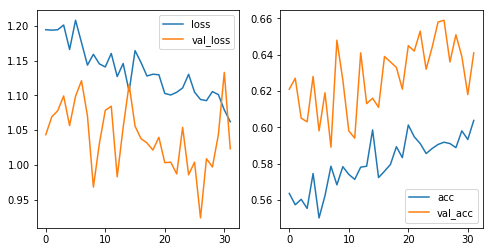

125/125 [==============================] - 11s - loss: 1.0621 - acc: 0.6038 - val_loss: 1.0232 - val_acc: 0.6410
Epoch 33/60
  2/125 [..............................] - ETA: 10s - loss: 1.0239 - acc: 0.5781

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=4000 / batch_size,
        epochs=60,
        validation_data=validation_generator,
        callbacks=[plot_losses],
        validation_steps=1000 / batch_size)

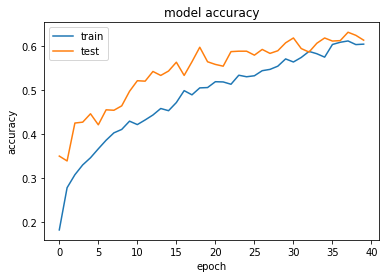

In [10]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

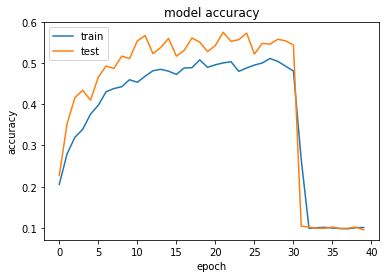

In [10]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

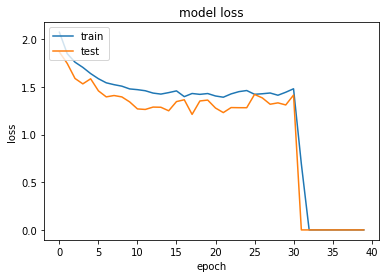

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
predicted = model.predict_generator(predict_generator, 3000 / batch_size)

In [42]:
predicted

array([[  2.60351956e-01,   3.30274832e-03,   2.03985870e-01, ...,
          1.15517047e-04,   4.17987436e-01,   1.06354035e-01],
       [  2.26724218e-03,   3.40878287e-05,   6.98539913e-02, ...,
          2.58297717e-07,   1.91381462e-02,   9.08671677e-01],
       [  4.05923606e-09,   5.75007231e-04,   1.25990468e-10, ...,
          2.09104091e-05,   7.60566537e-14,   3.06265069e-10],
       ..., 
       [  5.60074055e-04,   1.71720073e-01,   3.55183838e-05, ...,
          7.25354925e-02,   1.56442218e-06,   8.48888376e-05],
       [  9.99758422e-01,   8.43377202e-05,   4.45375990e-05, ...,
          1.84564630e-08,   6.59911893e-05,   4.57324713e-05],
       [  2.41817725e-06,   8.98094252e-02,   1.11065856e-06, ...,
          1.92318052e-01,   1.81967067e-07,   3.75795821e-06]], dtype=float32)

## Prediction

In [65]:
import re
import pandas as pd
output = pd.DataFrame({
            'uid': [re.match(r'validate/(.*).png',f).group(1) for f in predict_generator.filenames],
            'classes': [list(train_generator.class_indices)[np.argmax(p)] for p in predicted]}) \
        .reindex_axis(['uid','classes'],axis=1) \
        .set_index('uid')

In [98]:
print(output.shape)
output.head()

(3000, 1)


,classes
uid,
ship-file0280,ship
horse-file0247,truck
truck-file0296,horse
car-file0006,deer
cat-file0170,deer


In [101]:
submission = pd.read_csv('dl_lab_pictures.csv',sep='\t', index_col='uid')

In [102]:
submission.head()

,classes
uid,
airplane-file0000,NaN
airplane-file0001,NaN
airplane-file0002,NaN
airplane-file0003,NaN
airplane-file0004,NaN


In [106]:
submission['classes']=output['classes']
submission = submission.reset_index()

In [107]:
submission.head()

,uid,classes
0,airplane-file0000,truck
1,airplane-file0001,bird
2,airplane-file0002,ship
3,airplane-file0003,airplane
4,airplane-file0004,truck


In [110]:
submission.to_csv('dl_lab_pictures.csv',sep='\t',index=False)

In [ ]:
#os.system("scp labwork/submission.csv dl.alexey.naydenov@cluster.newprolab.com:/data/home/dl.alexey.naydenov")